In [ ]:
# ================================================================================================
# 셀 1: 모든 Import 및 모든 함수 정의
# ================================================================================================

# --- Part 1: Import 및 설정 ---
import os, sys, platform, random, time, json, warnings
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy import stats
import joblib

# sklearn
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor,
    RandomForestClassifier, GradientBoostingClassifier,
)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, f1_score,
)

# 선택적 라이브러리 확인
try:
    import xgboost as xgb; HAS_XGB = True
except ImportError:
    HAS_XGB = False; print("XGBoost 미설치 → 건너뜀")
try:
    import lightgbm as lgb; HAS_LGB = True
except ImportError:
    HAS_LGB = False; print("LightGBM 미설치 → 건너뜀")
try:
    import catboost as cb; HAS_CATBOOST = True
except ImportError:
    HAS_CATBOOST = False; print("CatBoost 미설치 → 건너뜀")

# 경고 필터 및 폰트 설정
warnings.filterwarnings("ignore")
try:
    plt.rcParams['font.family'] = 'AppleGothic' # 맥
except Exception:
    plt.rcParams['font.family'] ='Malgun Gothic' # 윈도우
plt.rcParams['axes.unicode_minus'] = False


In [ ]:


# --- Part 2: 모든 보조 함수 정의 ---

# 모델 정의
# ================================================================================================
# 2. 모델 정의 함수들 (오류 수정됨)
# ================================================================================================
def build_regression_models():
    """회귀 모델들"""
    models = {}
    
    models["RandomForest_Reg"] = RandomForestRegressor(
        n_estimators=300, min_samples_leaf=2, random_state=42, n_jobs=-1
    )
    
    models["LinearRegression"] = LinearRegression()
    
    models["GradientBoosting_Reg"] = GradientBoostingRegressor(
        n_estimators=200, learning_rate=0.1, random_state=42
    )
    
    if HAS_XGB:
        models["XGBoost_Reg"] = xgb.XGBRegressor(
            n_estimators=400, max_depth=5, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8,
            random_state=42, n_jobs=-1, verbosity=0
        )
    
    if HAS_LGB:
        models["LightGBM_Reg"] = lgb.LGBMRegressor(
            n_estimators=500, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8,
            random_state=42, n_jobs=-1, verbosity=-1
        )
    
    # 수정: 회귀 모델로 정정
    if HAS_CATBOOST:
        models["CatBoost_Reg"] = cb.CatBoostRegressor(
            iterations=500, learning_rate=0.05, depth=6,
            random_state=42, verbose=False
        )
    
    return models

def build_classification_models():
    """분류 모델들 (4등급)"""
    models = {}
    
    models["RandomForest_Clf"] = RandomForestClassifier(
        n_estimators=300, min_samples_leaf=2, random_state=42, 
        n_jobs=-1, class_weight='balanced'
    )
    
    models["GradientBoosting_Clf"] = GradientBoostingClassifier(
        n_estimators=200, learning_rate=0.1, random_state=42
    )
    
    models["LogisticRegression_Clf"] = LogisticRegression(
        multi_class="multinomial", solver="lbfgs", max_iter=1000,
        random_state=42, class_weight='balanced'
    )
    
    if HAS_XGB:
        models["XGBoost_Clf"] = xgb.XGBClassifier(
            n_estimators=400, max_depth=5, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8,
            objective="multi:softprob", num_class=4,
            tree_method="hist", random_state=42, n_jobs=-1, verbosity=0
        )
    
    if HAS_LGB:
        models["LightGBM_Clf"] = lgb.LGBMClassifier(
            n_estimators=500, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8,
            objective="multiclass", num_class=4,
            random_state=42, n_jobs=-1, verbosity=-1, is_unbalance=True
        )
    
    # 수정: auto_class_weights로 정정
    if HAS_CATBOOST:
        models["CatBoost_Clf"] = cb.CatBoostClassifier(
            iterations=500, learning_rate=0.05, depth=6,
            random_state=42, verbose=False, auto_class_weights='Balanced'
        )
    
    return models


# 데이터 처리 및 평가
def make_pipeline_unified(model, model_name, model_type):
    """통합 전처리 파이프라인"""
    if model_name in ["LinearRegression", "LogisticRegression_Clf"]:
        # 선형 모델은 정규화 필요
        pre = Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ])
    else:
        # 트리 기반 모델들은 정규화 불필요
        pre = Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
        ])
    return Pipeline(steps=[("pre", pre), ("model", model)])

def prepare_data_stratified(df, target_col, model_type, test_size=0.2, split_method='stratified'):
    """
    데이터 준비 - Stratified vs 시계열 분할 선택 가능
    
    Parameters:
    - split_method: 'stratified' 또는 'temporal'
    """
    work = df.sort_values('날짜').reset_index(drop=True).copy()
    dates = pd.to_datetime(work['날짜'])

    # 제외할 컬럼들
    not_use_col = [
        '날짜',
        '1처리장','2처리장','정화조','중계펌프장','합계','시설현대화',
        '3처리장','4처리장','합계', '합계_1일후','합계_2일후',
        '등급','등급_1일후','등급_2일후'
    ]
    
    drop_cols = [c for c in (set(not_use_col) | {target_col}) if c in work.columns]
    X_raw = work.drop(columns=drop_cols, errors="ignore")
    
    # 수치형 변환
    for c in X_raw.columns:
        X_raw[c] = pd.to_numeric(X_raw[c], errors="coerce")

    if model_type == "regression":
        y = pd.to_numeric(work[target_col], errors="coerce")
    else:  # classification
        y = work[target_col].astype("int64")

    # 결측치 제거
    valid_idx = (~X_raw.isnull().all(axis=1)) & (~pd.isnull(y))
    X_raw = X_raw[valid_idx].reset_index(drop=True)
    y = y[valid_idx].reset_index(drop=True)
    dates = dates[valid_idx].reset_index(drop=True)
    
    if split_method == 'stratified':
        # Stratified 분할 (분류에만 적용, 회귀는 일반 random split)
        if model_type == "classification":
            # 등급별 균등 분할
            sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
            train_idx, test_idx = next(sss.split(X_raw, y))
        else:
            # 회귀는 일반 랜덤 분할 (연속값이므로 stratify 불가)
            train_idx, test_idx = train_test_split(
                range(len(X_raw)), test_size=test_size, random_state=42
            )
            
        X_train, X_test = X_raw.iloc[train_idx].copy(), X_raw.iloc[test_idx].copy()
        y_train, y_test = y.iloc[train_idx].copy(), y.iloc[test_idx].copy()
        dates_train, dates_test = dates.iloc[train_idx].copy(), dates.iloc[test_idx].copy()
        
    else:  # temporal split
        # 기존 시계열 분할
        n = len(X_raw) # len(work)
        split = int(n * (1 - test_size))
        X_train, X_test = X_raw.iloc[:split].copy(), X_raw.iloc[split:].copy()
        y_train, y_test = y.iloc[:split].copy(), y.iloc[split:].copy()
        dates_train, dates_test = dates.iloc[:split].copy(), dates.iloc[split:].copy()

    feature_names = list(X_raw.columns)
    return X_train, X_test, y_train, y_test, feature_names, dates_train, dates_test

def evaluate_regression_model(model, model_name, X_train, X_test, y_train, y_test):
    """회귀 모델 평가 (수정됨)"""
    try:
        pipe = make_pipeline_unified(model, model_name, "regression")
        pipe.fit(X_train, y_train)
        
        y_pred = pipe.predict(X_test)
        
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        
        # MAPE (Mean Absolute Percentage Error)
        mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-8))) * 100
        
        # 올바른 return 문
        return {
            'model': model_name,
            'type': 'regression',
            'mae': mae,         # ← 계산된 값 사용
            'rmse': rmse,       # ← 계산된 값 사용
            'r2': r2,           # ← 계산된 값 사용
            'mape': mape,       # ← 계산된 값 사용
            'success': True     # ← 성공 시 True
        }, pipe, y_pred
        
    except Exception as e:
        # 실패 시에만 이 부분 실행
        return {
            'model': model_name,
            'type': 'regression',
            'mae': np.nan,
            'rmse': np.nan,
            'r2': np.nan,
            'mape': np.nan,
            'success': False,
            'error': str(e)
        }, None, None
        
def evaluate_classification_model(model, model_name, X_train, X_test, y_train, y_test):
    """분류 모델 평가"""
    try:
        pipe = make_pipeline_unified(model, model_name, "classification")
        pipe.fit(X_train, y_train)
        
        y_pred = pipe.predict(X_test)
        
        # 차원 문제 해결
        if isinstance(y_pred, np.ndarray) and y_pred.ndim > 1:
            y_pred = y_pred.ravel()
        
        acc = accuracy_score(y_test, y_pred)
        f1_macro = f1_score(y_test, y_pred, average="macro", zero_division=0)
        f1_weighted = f1_score(y_test, y_pred, average="weighted", zero_division=0)
        
        # 극값 분류 성능 (등급 0, 3로 수정: 0-base 변환 때문에)
        extreme_classes = [0, 3]  # 원래 1,4가 0,3으로 변환됨
        y_true_extreme = pd.Series(y_test).isin(extreme_classes).astype(int)
        y_pred_extreme = pd.Series(y_pred).isin(extreme_classes).astype(int)
        extreme_f1 = f1_score(y_true_extreme, y_pred_extreme, zero_division=0)
        
        return {
            'model': model_name,
            'type': 'classification',
            'accuracy': acc,
            'macro_f1': f1_macro,
            'weighted_f1': f1_weighted,
            'extreme_f1': extreme_f1,
            'success': True
        }, pipe, y_pred
        
    except Exception as e:
        return {
            'model': model_name,
            'type': 'classification',
            'accuracy': np.nan,
            'macro_f1': np.nan,
            'weighted_f1': np.nan,
            'extreme_f1': np.nan,
            'success': False,
            'error': str(e)
        }, None, None

def comprehensive_evaluation_comparison(center_name, df):
    """Stratified vs 시계열 분할 비교 평가"""
    print(f"\n{'='*70}")
    print(f"센터: {center_name} - Stratified vs 시계열 분할 비교")
    print(f"{'='*70}")
    
    # 데이터 확인
    print(f"데이터 크기: {len(df)}행, {len(df.columns)}컬럼")
    
    # 등급 분포 확인
    if '등급_1일후' in df.columns:
        grade_dist = df['등급_1일후'].value_counts().sort_index()
        print(f"등급 분포: {dict(grade_dist)}")
        
        # 불균형 정도 확인
        min_class = grade_dist.min()
        max_class = grade_dist.max()
        imbalance_ratio = max_class / min_class
        print(f"클래스 불균형 비율: {imbalance_ratio:.1f}:1 (최대:{max_class}, 최소:{min_class})")
    
    results = []
    
    # 두 가지 분할 방법 비교
    for split_method in ['temporal', 'stratified']:
        print(f"\n{'='*50}")
        print(f"분할 방법: {split_method.upper()}")
        print(f"{'='*50}")
        
        # =========================
        # 1. 회귀 모델 평가
        # =========================
        reg_method_name = "random_shuffle" if split_method == "stratified" else split_method
        print(f"\n--- 회귀 모델 평가 ({reg_method_name}) ---")
        
        try:
            X_train, X_test, y_train, y_test, feature_names, dates_train, dates_test = prepare_data_stratified(
                df, target_col="합계_1일후", model_type="regression", test_size=0.2, split_method=split_method
            )
            
            print(f"회귀용 데이터: 학습 {len(X_train)}행, 테스트 {len(X_test)}행")
            
            regression_models = build_regression_models()
            
            for model_name, model in tqdm(regression_models.items(), desc=f"회귀({reg_method_name})", leave=False):
                result, pipe, y_pred = evaluate_regression_model(model, model_name, X_train, X_test, y_train, y_test)
                result['center'] = center_name
                result['split_method'] = split_method
                results.append(result)
                
                if result['success']:
                    print(f"  {model_name:18s}: R²={result['r2']:.3f}, MAE={result['mae']:.0f}, MAPE={result['mape']:.1f}%")
                else:
                    print(f"  {model_name:18s}: 실패 - {result.get('error', '')[:50]}")
                    
        except Exception as e:
            print(f"회귀 모델 평가 실패 ({reg_method_name}): {e}")
        
        # =========================
        # 2. 분류 모델 평가
        # =========================
        print(f"\n--- 분류 모델 평가 ({split_method}) ---")
        
        try:
            X_train_clf, X_test_clf, y_train_clf, y_test_clf, feature_names_clf, _, _ = prepare_data_stratified(
                df, target_col="등급_1일후", model_type="classification", test_size=0.2, split_method=split_method
            )
            
            print(f"분류용 데이터: 학습 {len(X_train_clf)}행, 테스트 {len(X_test_clf)}행")
            
            # 테스트 세트 등급 분포 확인
            test_dist = pd.Series(y_test_clf).value_counts().sort_index()
            train_dist = pd.Series(y_train_clf).value_counts().sort_index()
            print(f"학습 세트 등급 분포: {dict(train_dist)}")
            print(f"테스트 세트 등급 분포: {dict(test_dist)}")
            
            classification_models = build_classification_models()
            
            for model_name, model in tqdm(classification_models.items(), desc=f"분류({split_method})", leave=False):
                result, pipe, y_pred = evaluate_classification_model(model, model_name, X_train_clf, X_test_clf, y_train_clf, y_test_clf)
                result['center'] = center_name
                result['split_method'] = split_method
                results.append(result)
                
                if result['success']:
                    print(f"  {model_name:18s}: ACC={result['accuracy']:.3f}, F1={result['macro_f1']:.3f}, 극값F1={result['extreme_f1']:.3f}")
                else:
                    print(f"  {model_name:18s}: 실패 - {result.get('error', '')[:50]}")
                    
        except Exception as e:
            print(f"분류 모델 평가 실패 ({split_method}): {e}")
    
    return results


# 최종 결과 처리 및 저장
def create_final_results_table(all_predictions):
    """최종 결과 테이블 생성"""
    results_df = pd.DataFrame(all_predictions)
    # 날짜 정렬
    results_df = results_df.sort_values(['date', 'center', 'task_type'])
    # 평가 지표 계산
    results_df = calculate_prediction_metrics_enhanced(results_df)
    
    return results_df

def calculate_prediction_metrics_enhanced(results_df):
    """향상된 예측 평가 지표 계산"""
    
    results_df = results_df.copy()
    
    # 평가 지표 컬럼 초기화
    results_df['absolute_error'] = None
    results_df['squared_error'] = None
    results_df['percentage_error'] = None
    results_df['correct_prediction'] = None
    results_df['residual'] = None
    
    for idx, row in results_df.iterrows():
        if pd.isna(row['actual_value']) or pd.isna(row['predicted_value']):
            continue
            
        actual = row['actual_value']
        predicted = row['predicted_value']
        
        if row['task_type'] == 'regression':
            # 회귀 평가 지표
            residual = actual - predicted
            abs_error = abs(residual)
            sq_error = residual ** 2
            pct_error = abs(residual) / (abs(actual) + 1e-8) * 100
            
            results_df.at[idx, 'residual'] = residual
            results_df.at[idx, 'absolute_error'] = abs_error
            results_df.at[idx, 'squared_error'] = sq_error
            results_df.at[idx, 'percentage_error'] = pct_error
            
        else:  # classification
            # 분류 평가 지표
            correct = 1 if int(actual) == int(predicted) else 0
            results_df.at[idx, 'correct_prediction'] = correct
    
    return results_df

def create_performance_summary(results_df):
    """성능 요약 생성"""
    
    summary = {}
    
    for center in results_df['center'].unique():
        center_data = results_df[results_df['center'] == center]
        summary[center] = {}
        
        for task_type in ['regression', 'classification']:
            task_data = center_data[center_data['task_type'] == task_type]
            task_data_clean = task_data.dropna(subset=['actual_value', 'predicted_value'])
            
            if len(task_data_clean) > 0:
                if task_type == 'regression':
                    summary[center]['regression'] = {
                        'model_name': task_data_clean.iloc[0]['model_name'],
                        'prediction_count': len(task_data_clean),
                        'mae': task_data_clean['absolute_error'].mean(),
                        'rmse': np.sqrt(task_data_clean['squared_error'].mean()),
                        'mape': task_data_clean['percentage_error'].mean(),
                        'r2_on_predictions': calculate_r2_on_predictions(
                            task_data_clean['actual_value'], 
                            task_data_clean['predicted_value']
                        )
                    }
                else:
                    summary[center]['classification'] = {
                        'model_name': task_data_clean.iloc[0]['model_name'],
                        'prediction_count': len(task_data_clean),
                        'accuracy': task_data_clean['correct_prediction'].mean(),
                        'correct_count': int(task_data_clean['correct_prediction'].sum()),
                        'total_count': len(task_data_clean)
                    }
    
    return summary

def calculate_r2_on_predictions(y_true, y_pred):
    """예측값에 대한 R² 계산"""
    from sklearn.metrics import r2_score
    y_true = pd.Series(y_true).astype(float)
    y_pred = pd.Series(y_pred).astype(float)
    if len(y_true) < 2:
        return None
    return r2_score(y_true, y_pred)


def print_final_results(results_df, performance_summary):
    """최종 결과 출력"""
    
    print(f"\n{'='*60}")
    print(f"=== 최종 예측 결과 요약 ===")
    print(f"{'='*60}")
    
    # 전체 요약
    total_predictions = len(results_df)
    date_range = f"{results_df['date'].min()} ~ {results_df['date'].max()}"
    centers = results_df['center'].unique()
    
    print(f"예측 기간: {date_range}")
    print(f"총 예측 건수: {total_predictions}")
    print(f"센터 수: {len(centers)} ({', '.join(centers)})")
    
    # 센터별 성능 요약
    for center, perf in performance_summary.items():
        print(f"\n--- {center.upper()} 센터 성능 ---")
        
        if 'regression' in perf:
            reg = perf['regression']
            print(f"  회귀 ({reg['model_name']}):")
            print(f"    예측 건수: {reg['prediction_count']}")
            print(f"    MAE: {reg['mae']:.2f}")
            print(f"    RMSE: {reg['rmse']:.2f}")
            print(f"    MAPE: {reg['mape']:.1f}%")
            if reg['r2_on_predictions'] is not None:
                print(f"    R²: {reg['r2_on_predictions']:.3f}")
        
        if 'classification' in perf:
            clf = perf['classification']
            print(f"  분류 ({clf['model_name']}):")
            print(f"    예측 건수: {clf['prediction_count']}")
            print(f"    정확도: {clf['accuracy']:.1%}")
            print(f"    정답 개수: {clf['correct_count']}/{clf['total_count']}")
    
    # 결과 테이블 미리보기
    print(f"\n--- 결과 테이블 미리보기 ---")
    display_columns = ['date', 'center', 'task_type', 'model_name', 'actual_value', 'predicted_value']
    if all(col in results_df.columns for col in display_columns):
        print(results_df[display_columns].head(10).to_string(index=False))

def save_final_results(results_df, performance_summary, training_results_df):
    """최종 결과 저장"""
    
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    base_filename = f"production_simulation_{timestamp}"
    
    try:
        # 1. 예측 결과 테이블 저장
        results_filename = f"{base_filename}_predictions.csv"
        results_df.to_csv(results_filename, index=False, encoding='utf-8-sig')
        print(f"\n예측 결과 저장: {results_filename}")
        
        # 2. 성능 요약 저장
        summary_data = []
        for center, perf in performance_summary.items():
            for task_type, metrics in perf.items():
                summary_row = {'center': center, 'task_type': task_type}
                summary_row.update(metrics)
                summary_data.append(summary_row)
        
        if summary_data:
            summary_df = pd.DataFrame(summary_data)
            summary_filename = f"{base_filename}_summary.csv"
            summary_df.to_csv(summary_filename, index=False, encoding='utf-8-sig')
            print(f"성능 요약 저장: {summary_filename}")
        
        # 3. 학습 결과 저장
        if len(training_results_df) > 0:
            training_filename = f"{base_filename}_training.csv"
            training_results_df.to_csv(training_filename, index=False, encoding='utf-8-sig')
            print(f"학습 결과 저장: {training_filename}")
        
        print(f"\n모든 결과가 저장되었습니다. 파일명 접두사: {base_filename}")
        
    except Exception as e:
        print(f"결과 저장 중 오류 발생: {e}")

# --- Part 3: Data Leakage 방지용 피처 엔지니어링 함수 ---
def make_features(df, cutoff_date=None):
    """
    파생변수 생성 함수 - Data Leakage 방지 버전
    
    Parameters:
    - df: 원본 데이터
    - cutoff_date: 타겟 변수 생성 제한 날짜 (None이면 전체 데이터 사용)
    """
    df = df.copy()
    
    # 날짜 정리 및 정렬
    df['날짜'] = pd.to_datetime(df['날짜'])
    df = df.sort_values('날짜').reset_index(drop=True)

    # 달/요일 숫자
    df['월'] = df['날짜'].dt.month
    df['요일'] = df['날짜'].dt.weekday

    # 계절/불쾌지수등급 숫자 매핑
    season_map = {'봄': 0, '여름': 1, '가을': 2, '겨울': 3}
    discomfort_map = {'쾌적': 0, '약간 불쾌': 1, '불쾌': 2, '매우 불쾌': 3, '극심한 불쾌': 4}
    df['계절'] = df['계절'].map(season_map).astype('Int64')
    df['불쾌지수등급'] = df['불쾌지수등급'].map(discomfort_map).astype('Int64')

    # 강수량 시차 피처
    df['강수량_1일전'] = df['일_일강수량(mm)'].shift(1)
    df['강수량_2일전'] = df['일_일강수량(mm)'].shift(2)
    df['강수량_1일_누적'] = df['일_일강수량(mm)'].rolling(1, min_periods=1).sum()
    df['강수량_2일_누적'] = df['일_일강수량(mm)'].rolling(2, min_periods=1).sum()
    df['강수량_3일_누적'] = df['일_일강수량(mm)'].rolling(3, min_periods=1).sum()
    df['강수량_5일_누적'] = df['일_일강수량(mm)'].rolling(5, min_periods=1).sum()
    df['강수량_7일_누적'] = df['일_일강수량(mm)'].rolling(7, min_periods=1).sum()

    df['일교차'] = df['일_최고기온(°C)'] - df['일_최저기온(°C)']
    df['폭우_여부'] = (df['일_일강수량(mm)'] >= 80).astype(int)
    
    # 체감온도 계산
    if '일_평균기온(°C)' in df.columns:
        T = pd.to_numeric(df['일_평균기온(°C)'], errors='coerce')
    else:
        T = pd.Series(np.nan, index=df.index)
    if '일_평균풍속(m/s)' in df.columns:
        V_ms = pd.to_numeric(df['일_평균풍속(m/s)'], errors='coerce')
    else:
        V_ms = pd.Series(np.nan, index=df.index)
    if '평균습도(%)' in df.columns:
        RH = pd.to_numeric(df['평균습도(%)'], errors='coerce')
    else:
        RH = pd.Series(np.nan, index=df.index)

    # 윈드칠
    V_kmh = V_ms * 3.6
    wct_raw = 13.12 + 0.6215*T - 11.37*np.power(V_kmh, 0.16) + 0.3965*T*np.power(V_kmh, 0.16)
    wc_valid = (T <= 10.0) & (V_kmh >= 4.8)
    wct = T.copy()
    wct[wc_valid] = wct_raw[wc_valid]

    # 열지수
    T_f = T * 9/5 + 32
    HI_f = (-42.379 + 2.04901523*T_f + 10.14333127*RH
            - 0.22475541*T_f*RH - 0.00683783*T_f**2 - 0.05481717*RH**2
            + 0.00122874*T_f**2*RH + 0.00085282*T_f*RH**2
            - 0.00000199*T_f**2*RH**2)
    mask_low = (RH < 13) & (T_f >= 80) & (T_f <= 112)
    adj_low = ((13 - RH)/4) * np.sqrt((17 - np.abs(T_f - 95))/17)
    HI_f = HI_f.where(~mask_low, HI_f - adj_low)
    mask_high = (RH > 85) & (T_f >= 80) & (T_f <= 87)
    adj_high = ((RH - 85)/10) * ((87 - T_f)/5)
    HI_f = HI_f.where(~mask_high, HI_f + adj_high)
    hi_valid = (T_f >= 80) & (RH >= 40)
    HI_c = (HI_f - 32) * 5/9
    hi = T.copy()
    hi[hi_valid] = HI_c[hi_valid]

    # 스테드먼 체감온도
    e = (RH/100.0) * 6.105 * np.exp(17.27*T/(237.7 + T))
    at = T + 0.33*e - 0.70*V_ms - 4.00

    # 최종 체감온도
    apparent = at.copy()
    apparent[hi_valid] = hi[hi_valid]
    apparent[wc_valid] = wct[wc_valid]
    df['체감온도(°C)'] = apparent
    
    # 분류용 등급 계산
    q = df['합계'].dropna().quantile([0.15, 0.70, 0.90])
    q15, q70, q90 = float(q.loc[0.15]), float(q.loc[0.70]), float(q.loc[0.90])

    def categorize(x):
        if pd.isna(x):
            return np.nan
        if x < q15:
            return 0
        elif x < q70:
            return 1
        elif x < q90:
            return 2
        else:
            return 3

    df['등급'] = df['합계'].apply(categorize)
    
    # 타겟 변수 생성 (핵심 수정 부분)
    if cutoff_date is not None:
        cutoff = pd.to_datetime(cutoff_date)
        
        # 타겟 변수 초기화
        df['합계_1일후'] = np.nan
        df['합계_2일후'] = np.nan
        df['등급_1일후'] = np.nan
        df['등급_2일후'] = np.nan
        
        # cutoff_date 내에서만 타겟 변수 생성
        for i in range(len(df)):
            current_date = df.loc[i, '날짜']
            
            if i + 1 < len(df) and current_date <= cutoff:
                next_date = df.loc[i+1, '날짜']
                if next_date <= cutoff:
                    df.loc[i, '합계_1일후'] = df.loc[i+1, '합계']
                    df.loc[i, '등급_1일후'] = df.loc[i+1, '등급']
            
            if i + 2 < len(df) and current_date <= cutoff:
                next2_date = df.loc[i+2, '날짜']
                if next2_date <= cutoff:
                    df.loc[i, '합계_2일후'] = df.loc[i+2, '합계']
                    df.loc[i, '등급_2일후'] = df.loc[i+2, '등급']
    else:
        # 기존 방식
        df['합계_1일후'] = df['합계'].shift(-1)
        df['합계_2일후'] = df['합계'].shift(-2)
        df['등급_1일후'] = df['등급'].shift(-1).astype('Int64')
        df['등급_2일후'] = df['등급'].shift(-2).astype('Int64')

    # 컷 기준 저장
    df.attrs['cutoffs'] = {"q15": q15, "q70": q70, "q90": q90}

    # 결측 제거 및 리셋
    df = df.dropna().reset_index(drop=True)
    
    # 6월 데이터 제거
    df = df[df["날짜"] < "2025-06-01"]
    
    return df

def make_features_for_prediction(historical_df, future_df):
    """새로운 데이터에 대한 파생변수 생성 (과거 데이터 활용)"""
    # 전체 데이터 결합
    combined_df = pd.concat([historical_df, future_df], ignore_index=True)
    combined_df['날짜'] = pd.to_datetime(combined_df['날짜'])
    combined_df = combined_df.sort_values('날짜').reset_index(drop=True)
    
    # 기본 파생변수들만 생성 (lag 변수 중심)
    combined_df['월'] = combined_df['날짜'].dt.month
    combined_df['요일'] = combined_df['날짜'].dt.weekday
    
    # 계절/불쾌지수 매핑
    season_map = {'봄': 0, '여름': 1, '가을': 2, '겨울': 3}
    discomfort_map = {'쾌적': 0, '약간 불쾌': 1, '불쾌': 2, '매우 불쾌': 3, '극심한 불쾌': 4}
    combined_df['계절'] = combined_df['계절'].map(season_map).astype('Int64')
    combined_df['불쾌지수등급'] = combined_df['불쾌지수등급'].map(discomfort_map).astype('Int64')
    
    # 시차 변수들
    combined_df['강수량_1일전'] = combined_df['일_일강수량(mm)'].shift(1)
    combined_df['강수량_2일전'] = combined_df['일_일강수량(mm)'].shift(2)
    combined_df['강수량_1일_누적'] = combined_df['일_일강수량(mm)'].rolling(1, min_periods=1).sum()
    combined_df['강수량_2일_누적'] = combined_df['일_일강수량(mm)'].rolling(2, min_periods=1).sum()
    combined_df['강수량_3일_누적'] = combined_df['일_일강수량(mm)'].rolling(3, min_periods=1).sum()
    combined_df['강수량_5일_누적'] = combined_df['일_일강수량(mm)'].rolling(5, min_periods=1).sum()
    combined_df['강수량_7일_누적'] = combined_df['일_일강수량(mm)'].rolling(7, min_periods=1).sum()
    
    combined_df['일교차'] = combined_df['일_최고기온(°C)'] - combined_df['일_최저기온(°C)']
    combined_df['폭우_여부'] = (combined_df['일_일강수량(mm)'] >= 80).astype(int)
    
    # 체감온도 계산 (동일한 로직)
    T = pd.to_numeric(combined_df.get('일_평균기온(°C)', np.nan), errors='coerce')
    V_ms = pd.to_numeric(combined_df.get('일_평균풍속(m/s)', np.nan), errors='coerce')
    RH = pd.to_numeric(combined_df.get('평균습도(%)', np.nan), errors='coerce')
    
    # 체감온도 계산 (간단 버전)
    e = (RH/100.0) * 6.105 * np.exp(17.27*T/(237.7 + T))
    combined_df['체감온도(°C)'] = T + 0.33*e - 0.70*V_ms - 4.00
    
    # 새 데이터 부분만 반환
    historical_len = len(historical_df)
    return combined_df.iloc[historical_len:].reset_index(drop=True)


# --- Part 4: 메인 파이프라인 및 실행기 함수 ---
def select_and_train_best_models_safe(center_name, train_data, evaluation_results):
    """안전한 모델 선택 및 학습"""
    
    results_df = pd.DataFrame(evaluation_results)
    successful_results = results_df[results_df['success'] == True]
    
    if len(successful_results) == 0:
        print(f"    성공한 모델이 없습니다.")
        return None
    
    best_models = {}
    
    # 회귀 최고 성능 모델
    reg_results = successful_results[successful_results['type'] == 'regression']
    if len(reg_results) > 0:
        best_reg = reg_results.loc[reg_results['r2'].idxmax()]
        print(f"    최고 회귀 모델: {best_reg['model']} (R²={best_reg['r2']:.3f})")
        
        reg_pipeline = retrain_on_full_safe_data(train_data, best_reg['model'], 'regression', best_reg['split_method'])
        
        if reg_pipeline:
            best_models['regression'] = {
                'model_name': best_reg['model'],
                'pipeline': reg_pipeline['pipeline'],
                'feature_names': reg_pipeline['feature_names'],
                'performance': dict(best_reg),
                'split_method': best_reg['split_method']
            }
    
    # 분류 최고 성능 모델
    clf_results = successful_results[successful_results['type'] == 'classification']
    if len(clf_results) > 0:
        best_clf = clf_results.loc[clf_results['macro_f1'].idxmax()]
        print(f"    최고 분류 모델: {best_clf['model']} (F1={best_clf['macro_f1']:.3f})")
        
        clf_pipeline = retrain_on_full_safe_data(train_data, best_clf['model'], 'classification', best_clf['split_method'])
        
        if clf_pipeline:
            best_models['classification'] = {
                'model_name': best_clf['model'],
                'pipeline': clf_pipeline['pipeline'],
                'feature_names': clf_pipeline['feature_names'],
                'performance': dict(best_clf),
                'split_method': best_clf['split_method']
            }
    
    return best_models if best_models else None

def retrain_on_full_safe_data(train_data, model_name, model_type, split_method):
    """안전한 전체 데이터 재학습"""
    
    try:
        target_col = "합계_1일후" if model_type == "regression" else "등급_1일후"
        
        # 전체 데이터를 train으로 사용 (test_size를 아주 작게)
        X_train, X_test, y_train, y_test, feature_names, _, _ = prepare_data_stratified(
            train_data, target_col=target_col, model_type=model_type, 
            test_size=0.01, split_method=split_method
        )
        
        # 전체 결합
        X_all = pd.concat([X_train, X_test], ignore_index=True)
        y_all = pd.concat([y_train, y_test], ignore_index=True)
        
        # 모델 학습
        if model_type == "regression":
            models = build_regression_models()
        else:
            models = build_classification_models()
        
        model = models[model_name]
        pipeline = make_pipeline_unified(model, model_name, model_type)
        pipeline.fit(X_all, y_all)
        
        return {'pipeline': pipeline, 'feature_names': feature_names}
        
    except Exception as e:
        print(f"    모델 재학습 실패 ({model_name}): {e}")
        return None

def make_predictions_safe(center_name, future_data, trained_models):
    """안전한 예측 수행"""
    
    predictions = []
    
    for task_type, model_info in trained_models.items():
        try:
            pipeline = model_info['pipeline']
            feature_names = model_info['feature_names']
            model_name = model_info['model_name']
            
            # 예측 데이터 준비
            X_future = prepare_prediction_features(future_data, feature_names)
            
            if X_future is None or len(X_future) == 0:
                continue
            
            # 예측 수행
            y_pred = pipeline.predict(X_future)
            print(f"    {task_type} 예측 완료: {len(y_pred)}개")
            
            # 결과 저장
            for i in range(len(X_future)):
                pred_result = {
                    'date': future_data.iloc[i]['날짜'],
                    'center': center_name,
                    'task_type': task_type,
                    'model_name': model_name,
                    'target_column': "합계_1일후" if task_type == "regression" else "등급_1일후",
                    'actual_value': None,  # 운영 환경에서는 모름
                    'predicted_value': float(y_pred[i])
                }
                predictions.append(pred_result)
                
        except Exception as e:
            print(f"    {task_type} 예측 실패: {e}")
    
    return predictions

def prepare_prediction_features(future_data, expected_features):
    """예측용 피처 준비"""
    
    not_use_col = [
        '날짜', '1처리장','2처리장','정화조','중계펌프장','합계','시설현대화',
        '3처리장','4처리장','합계', '합계_1일후','합계_2일후',
        '등급','등급_1일후','등급_2일후'
    ]
    
    # 피처 선택
    available_cols = [col for col in future_data.columns if col not in not_use_col]
    X_future = future_data[available_cols].copy()
    
    # 수치형 변환
    for c in X_future.columns:
        X_future[c] = pd.to_numeric(X_future[c], errors="coerce")
    
    # 누락된 피처 처리
    missing_features = set(expected_features) - set(X_future.columns)
    if missing_features:
        for feature in missing_features:
            X_future[feature] = 0
    
    # 피처 순서 맞춤
    X_future = X_future[expected_features].copy()
    
    return X_future

def load_original_data():
    """원본 데이터 로드"""
    nanji_raw = pd.read_csv('../data/processed/center_season/nanji/난지_merged.csv', encoding='utf-8-sig')
    jungnang_raw = pd.read_csv('../data/processed/center_season/jungnang/중랑_merged.csv', encoding='utf-8-sig')
    seonam_raw = pd.read_csv('../data/processed/center_season/seonam/서남_merged.csv', encoding='utf-8-sig')
    tancheon_raw = pd.read_csv('../data/processed/center_season/tancheon/탄천_merged.csv', encoding='utf-8-sig')
    
    return {
        "nanji": nanji_raw,
        "jungnang": jungnang_raw,
        "seonam": seonam_raw,
        "tancheon": tancheon_raw
    }

def complete_production_simulation_safe(centers, cutoff_date='2025-05-20'):
    """Data Leakage 방지 완전 파이프라인"""
    print(f"{'='*80}")
    print(f"Data Leakage 방지 운영 환경 시뮬레이션")
    print(f"학습 기간: ~ {cutoff_date}")
    print(f"예측 기간: {cutoff_date} 이후")
    print(f"{'='*80}")
    
    if centers is None:
        try:
            centers = load_original_data()
        except:
            print("데이터를 로드할 수 없습니다.")
            return None
    
    cutoff = pd.to_datetime(cutoff_date)
    all_training_results = []
    best_models_by_center = {}
    all_predictions = []
    
    # 각 센터별 처리
    for center_name, df_raw in centers.items():
        print(f"\n[{center_name.upper()} 센터 처리]")
        
        # 원본 데이터 날짜 기준 분할
        df_raw['날짜'] = pd.to_datetime(df_raw['날짜'])
        df_raw = df_raw.sort_values('날짜').reset_index(drop=True)
        
        raw_train_data = df_raw[df_raw['날짜'] <= cutoff].copy()
        raw_future_data = df_raw[df_raw['날짜'] > cutoff].copy()
        
        print(f"  원본 학습 데이터: {len(raw_train_data)}행")
        print(f"  원본 예측 데이터: {len(raw_future_data)}행")
        
        if len(raw_train_data) < 50 or len(raw_future_data) == 0:
            print(f"  데이터 부족으로 건너뜀")
            continue
        
        # 1단계: 학습용 데이터 안전하게 준비
        train_data_safe = make_features(raw_train_data, cutoff_date=cutoff_date)
        print(f"  처리된 학습 데이터: {len(train_data_safe)}행")
        
        # 2단계: 모델 평가 및 선택
        center_results = comprehensive_evaluation_comparison(center_name, train_data_safe)
        all_training_results.extend(center_results)
        
        center_best_models = select_and_train_best_models_safe(center_name, train_data_safe, center_results)
        if center_best_models:
            best_models_by_center[center_name] = center_best_models
        
        # 3단계: 예측용 데이터 준비 (과거 정보만 활용)
        if len(raw_future_data) > 0 and center_name in best_models_by_center:
            future_data_with_features = make_features_for_prediction(raw_train_data, raw_future_data)
            
            # 4단계: 예측 수행
            center_predictions = make_predictions_safe(
                center_name, future_data_with_features, best_models_by_center[center_name]
            )
            all_predictions.extend(center_predictions)
    
    # 5단계: 결과 정리
    if not all_predictions:
        print("예측 결과가 없습니다.")
        return None
    
    final_results_table = create_final_results_table(all_predictions)
    performance_summary = create_performance_summary(final_results_table)
    
    print_final_results(final_results_table, performance_summary)
    save_final_results(final_results_table, performance_summary, pd.DataFrame(all_training_results))
    
    return final_results_table, best_models_by_center, performance_summary


def run_safe_production_pipeline(cutoff_date='2025-05-20'):
    """안전한 파이프라인 실행"""
    print("Data Leakage 방지 파이프라인을 시작합니다...")
    start_time = time.time()
    
    # 데이터 로드
    centers = load_original_data()
    if centers is None:
        return None

    # ✅ 수정된 코드: centers를 명시적으로 전달
    results = complete_production_simulation_safe(centers=centers, cutoff_date=cutoff_date)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    print(f"\n파이프라인 실행 완료! 소요시간: {elapsed_time:.1f}초")
    
    return results


# ================================================================================================
# 3번 구현: 실제 정답과 예측값 비교
# ================================================================================================

def add_actual_values_to_predictions(all_predictions, original_centers_data, cutoff_date='2025-05-20'):
    """
    예측 결과에 실제 정답값 추가
    
    Parameters:
    - all_predictions: 예측 결과 리스트
    - original_centers_data: 원본 센터 데이터 딕셔너리
    - cutoff_date: 학습/예측 분할 기준일
    """
    cutoff = pd.to_datetime(cutoff_date)
    
    print(f"\n실제 정답값 매칭 중...")
    
    for pred in tqdm(all_predictions, desc="정답 매칭"):
        center_name = pred['center']
        pred_date = pd.to_datetime(pred['date'])
        task_type = pred['task_type']
        
        if center_name not in original_centers_data:
            continue
            
        # 해당 센터의 예측 날짜 이후 데이터 가져오기
        center_data = original_centers_data[center_name].copy()
        center_data['날짜'] = pd.to_datetime(center_data['날짜'])
        
        # 예측 날짜 다음날 데이터 찾기 (1일후 예측이므로)
        target_date = pred_date + pd.Timedelta(days=1)
        
        # 해당 날짜 데이터 찾기
        matching_rows = center_data[center_data['날짜'] == target_date]
        
        if len(matching_rows) > 0:
            actual_row = matching_rows.iloc[0]
            
            if task_type == 'regression':
                # 회귀: 합계 값
                actual_value = actual_row.get('합계', None)
            else:
                # 분류: 등급 계산 (동일한 quantile 기준 사용)
                center_historical = center_data[center_data['날짜'] <= cutoff]
                if '합계' in center_historical.columns and len(center_historical) > 0:
                    q = center_historical['합계'].dropna().quantile([0.15, 0.70, 0.90])
                    q15, q70, q90 = float(q.loc[0.15]), float(q.loc[0.70]), float(q.loc[0.90])
                    
                    actual_total = actual_row.get('합계', None)
                    if pd.notna(actual_total):
                        if actual_total < q15:
                            actual_value = 0
                        elif actual_total < q70:
                            actual_value = 1
                        elif actual_total < q90:
                            actual_value = 2
                        else:
                            actual_value = 3
                    else:
                        actual_value = None
                else:
                    actual_value = None
            
            pred['actual_value'] = actual_value
        else:
            pred['actual_value'] = None
    
    # 매칭 결과 요약
    total_predictions = len(all_predictions)
    matched_predictions = sum(1 for p in all_predictions if p['actual_value'] is not None)
    match_rate = matched_predictions / total_predictions * 100
    
    print(f"정답 매칭 완료: {matched_predictions}/{total_predictions} ({match_rate:.1f}%)")
    
    return all_predictions

def calculate_production_performance(predictions_with_actuals):
    """
    실제 운영 성능 계산
    """
    results_df = pd.DataFrame(predictions_with_actuals)
    
    # 정답이 있는 예측만 필터링
    valid_predictions = results_df.dropna(subset=['actual_value', 'predicted_value'])
    
    if len(valid_predictions) == 0:
        print("평가 가능한 예측이 없습니다.")
        return None
    
    performance_summary = {}
    
    for center in valid_predictions['center'].unique():
        center_data = valid_predictions[valid_predictions['center'] == center]
        performance_summary[center] = {}
        
        for task_type in ['regression', 'classification']:
            task_data = center_data[center_data['task_type'] == task_type]
            
            if len(task_data) == 0:
                continue
                
            y_true = task_data['actual_value'].values
            y_pred = task_data['predicted_value'].values
            
            if task_type == 'regression':
                # 회귀 평가 지표
                mae = mean_absolute_error(y_true, y_pred)
                rmse = np.sqrt(mean_squared_error(y_true, y_pred))
                r2 = r2_score(y_true, y_pred)
                mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
                
                performance_summary[center]['regression'] = {
                    'model_name': task_data.iloc[0]['model_name'],
                    'prediction_count': len(task_data),
                    'mae': mae,
                    'rmse': rmse,
                    'r2': r2,
                    'mape': mape,
                    'mean_actual': np.mean(y_true),
                    'mean_predicted': np.mean(y_pred)
                }
                
            else:
                # 분류 평가 지표
                accuracy = accuracy_score(y_true, y_pred)
                f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
                f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)
                
                # 극값 분류 성능 (등급 0, 3)
                extreme_classes = [0, 3]
                y_true_extreme = pd.Series(y_true).isin(extreme_classes).astype(int)
                y_pred_extreme = pd.Series(y_pred).isin(extreme_classes).astype(int)
                extreme_f1 = f1_score(y_true_extreme, y_pred_extreme, zero_division=0)
                
                performance_summary[center]['classification'] = {
                    'model_name': task_data.iloc[0]['model_name'],
                    'prediction_count': len(task_data),
                    'accuracy': accuracy,
                    'macro_f1': f1_macro,
                    'weighted_f1': f1_weighted,
                    'extreme_f1': extreme_f1,
                    'correct_count': int(np.sum(y_true == y_pred)),
                    'total_count': len(y_true)
                }
    
    return performance_summary

def print_production_performance(performance_summary, training_performance=None):
    """
    실제 운영 성능 출력 (학습 성능과 비교)
    """
    print(f"\n{'='*70}")
    print(f"실제 운영 환경 성능 평가")
    print(f"{'='*70}")
    
    for center, perf in performance_summary.items():
        print(f"\n--- {center.upper()} 센터 ---")
        
        if 'regression' in perf:
            reg = perf['regression']
            print(f"  회귀 모델 ({reg['model_name']}):")
            print(f"    예측 건수: {reg['prediction_count']}")
            print(f"    실제 운영 성능:")
            print(f"      MAE: {reg['mae']:.2f}")
            print(f"      RMSE: {reg['rmse']:.2f}")
            print(f"      R²: {reg['r2']:.3f}")
            print(f"      MAPE: {reg['mape']:.1f}%")
            print(f"    평균값 비교:")
            print(f"      실제: {reg['mean_actual']:.1f}")
            print(f"      예측: {reg['mean_predicted']:.1f}")
            
        if 'classification' in perf:
            clf = perf['classification']
            print(f"  분류 모델 ({clf['model_name']}):")
            print(f"    예측 건수: {clf['prediction_count']}")
            print(f"    실제 운영 성능:")
            print(f"      정확도: {clf['accuracy']:.1%}")
            print(f"      Macro F1: {clf['macro_f1']:.3f}")
            print(f"      Weighted F1: {clf['weighted_f1']:.3f}")
            print(f"      극값 F1: {clf['extreme_f1']:.3f}")
            print(f"    정답 개수: {clf['correct_count']}/{clf['total_count']}")

def create_performance_comparison_plot(performance_summary):
    """
    성능 비교 시각화
    """
    centers = list(performance_summary.keys())
    n_centers = len(centers)
    
    if n_centers == 0:
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('실제 운영 환경 성능 비교', fontsize=16)
    
    # 회귀 성능 비교
    reg_centers = [c for c in centers if 'regression' in performance_summary[c]]
    if reg_centers:
        ax1 = axes[0, 0]
        r2_scores = [performance_summary[c]['regression']['r2'] for c in reg_centers]
        ax1.bar(reg_centers, r2_scores, color='skyblue', alpha=0.7)
        ax1.set_title('회귀 모델 R² 점수')
        ax1.set_ylabel('R² Score')
        ax1.tick_params(axis='x', rotation=45)
        
        ax2 = axes[0, 1]
        mape_scores = [performance_summary[c]['regression']['mape'] for c in reg_centers]
        ax2.bar(reg_centers, mape_scores, color='lightcoral', alpha=0.7)
        ax2.set_title('회귀 모델 MAPE (%)')
        ax2.set_ylabel('MAPE (%)')
        ax2.tick_params(axis='x', rotation=45)
    
    # 분류 성능 비교
    clf_centers = [c for c in centers if 'classification' in performance_summary[c]]
    if clf_centers:
        ax3 = axes[1, 0]
        accuracy_scores = [performance_summary[c]['classification']['accuracy'] for c in clf_centers]
        ax3.bar(clf_centers, accuracy_scores, color='lightgreen', alpha=0.7)
        ax3.set_title('분류 모델 정확도')
        ax3.set_ylabel('Accuracy')
        ax3.tick_params(axis='x', rotation=45)
        
        ax4 = axes[1, 1]
        f1_scores = [performance_summary[c]['classification']['macro_f1'] for c in clf_centers]
        ax4.bar(clf_centers, f1_scores, color='gold', alpha=0.7)
        ax4.set_title('분류 모델 Macro F1')
        ax4.set_ylabel('Macro F1 Score')
        ax4.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

# ================================================================================================
# 기존 complete_production_simulation_safe 함수 수정
# ================================================================================================

def complete_production_simulation_with_evaluation(centers, cutoff_date='2025-05-20'):
    """
    실제 정답 평가가 포함된 완전한 파이프라인
    """
    print(f"{'='*80}")
    print(f"Data Leakage 방지 운영 환경 시뮬레이션 (실제 정답 평가 포함)")
    print(f"학습 기간: ~ {cutoff_date}")
    print(f"예측 기간: {cutoff_date} 이후")
    print(f"{'='*80}")
    
    if centers is None:
        try:
            centers = load_original_data()
        except:
            print("데이터를 로드할 수 없습니다.")
            return None
    
    cutoff = pd.to_datetime(cutoff_date)
    all_training_results = []
    best_models_by_center = {}
    all_predictions = []
    
    # 각 센터별 처리 (기존과 동일)
    for center_name, df_raw in centers.items():
        print(f"\n[{center_name.upper()} 센터 처리]")
        
        df_raw['날짜'] = pd.to_datetime(df_raw['날짜'])
        df_raw = df_raw.sort_values('날짜').reset_index(drop=True)
        
        raw_train_data = df_raw[df_raw['날짜'] <= cutoff].copy()
        raw_future_data = df_raw[df_raw['날짜'] > cutoff].copy()
        
        print(f"  원본 학습 데이터: {len(raw_train_data)}행")
        print(f"  원본 예측 데이터: {len(raw_future_data)}행")
        
        if len(raw_train_data) < 50 or len(raw_future_data) == 0:
            print(f"  데이터 부족으로 건너뜀")
            continue
        
        train_data_safe = make_features(raw_train_data, cutoff_date=cutoff_date)
        print(f"  처리된 학습 데이터: {len(train_data_safe)}행")
        
        center_results = comprehensive_evaluation_comparison(center_name, train_data_safe)
        all_training_results.extend(center_results)
        
        center_best_models = select_and_train_best_models_safe(center_name, train_data_safe, center_results)
        if center_best_models:
            best_models_by_center[center_name] = center_best_models
        
        if len(raw_future_data) > 0 and center_name in best_models_by_center:
            future_data_with_features = make_features_for_prediction(raw_train_data, raw_future_data)
            center_predictions = make_predictions_safe(
                center_name, future_data_with_features, best_models_by_center[center_name]
            )
            all_predictions.extend(center_predictions)
    
    if not all_predictions:
        print("예측 결과가 없습니다.")
        return None
    
    # ★ 새로 추가: 실제 정답값 매칭
    predictions_with_actuals = add_actual_values_to_predictions(
        all_predictions, centers, cutoff_date
    )
    
    # ★ 새로 추가: 실제 운영 성능 계산
    production_performance = calculate_production_performance(predictions_with_actuals)
    
    if production_performance:
        print_production_performance(production_performance)
        create_performance_comparison_plot(production_performance)
    
    # 기존 결과 정리
    final_results_table = create_final_results_table(predictions_with_actuals)
    performance_summary = create_performance_summary(final_results_table)
    
    save_final_results(final_results_table, performance_summary, pd.DataFrame(all_training_results))
    
    return final_results_table, best_models_by_center, production_performance

# ================================================================================================
# 업데이트된 실행 함수
# ================================================================================================

def run_complete_production_pipeline(cutoff_date='2025-05-20'):
    """실제 정답 평가가 포함된 파이프라인 실행"""
    print("실제 정답 평가가 포함된 파이프라인을 시작합니다...")
    start_time = time.time()
    
    centers = load_original_data()
    if centers is None:
        return None

    results = complete_production_simulation_with_evaluation(centers=centers, cutoff_date=cutoff_date)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    print(f"\n파이프라인 실행 완료! 소요시간: {elapsed_time:.1f}초")
    
    return results

실제 정답 평가가 포함된 파이프라인을 시작합니다...
Data Leakage 방지 운영 환경 시뮬레이션 (실제 정답 평가 포함)
학습 기간: ~ 2025-05-20
예측 기간: 2025-05-20 이후

[NANJI 센터 처리]
  원본 학습 데이터: 3062행
  원본 예측 데이터: 41행
  처리된 학습 데이터: 3058행

센터: nanji - Stratified vs 시계열 분할 비교
데이터 크기: 3058행, 44컬럼
등급 분포: {0.0: 458, 1.0: 1682, 2.0: 611, 3.0: 307}
클래스 불균형 비율: 5.5:1 (최대:1682, 최소:307)

분할 방법: TEMPORAL

--- 회귀 모델 평가 (temporal) ---
회귀용 데이터: 학습 2446행, 테스트 612행


회귀(temporal):  17%|█▋        | 1/6 [00:00<00:03,  1.30it/s]

  RandomForest_Reg  : R²=0.555, MAE=49338, MAPE=7.2%
  LinearRegression  : R²=0.521, MAE=61288, MAPE=9.5%


회귀(temporal):  50%|█████     | 3/6 [00:02<00:02,  1.24it/s]

  GradientBoosting_Reg: R²=0.316, MAE=65378, MAPE=10.3%


회귀(temporal):  67%|██████▋   | 4/6 [00:02<00:01,  1.48it/s]

  XGBoost_Reg       : R²=0.471, MAE=57791, MAPE=8.7%


회귀(temporal):  83%|████████▎ | 5/6 [00:04<00:01,  1.02s/it]

  LightGBM_Reg      : R²=0.481, MAE=53737, MAPE=7.9%


  CatBoost_Reg      : R²=0.529, MAE=49454, MAPE=7.3%

--- 분류 모델 평가 (temporal) ---
분류용 데이터: 학습 2446행, 테스트 612행
학습 세트 등급 분포: {0: 453, 1: 1309, 2: 435, 3: 249}
테스트 세트 등급 분포: {0: 5, 1: 373, 2: 176, 3: 58}


분류(temporal):  17%|█▋        | 1/6 [00:00<00:01,  3.53it/s]

  RandomForest_Clf  : ACC=0.750, F1=0.485, 극값F1=0.514


분류(temporal):  33%|███▎      | 2/6 [00:06<00:15,  3.91s/it]

  GradientBoosting_Clf: ACC=0.703, F1=0.500, 극값F1=0.416
  LogisticRegression_Clf: ACC=0.317, F1=0.310, 극값F1=0.201


분류(temporal):  67%|██████▋   | 4/6 [00:08<00:03,  1.97s/it]

  XGBoost_Clf       : ACC=0.711, F1=0.556, 극값F1=0.493


분류(temporal):  83%|████████▎ | 5/6 [00:15<00:03,  3.56s/it]

  LightGBM_Clf      : ACC=0.683, F1=0.502, 극값F1=0.434


  CatBoost_Clf      : ACC=0.672, F1=0.509, 극값F1=0.422

분할 방법: STRATIFIED

--- 회귀 모델 평가 (random_shuffle) ---
회귀용 데이터: 학습 2446행, 테스트 612행


회귀(random_shuffle):  17%|█▋        | 1/6 [00:00<00:03,  1.28it/s]

  RandomForest_Reg  : R²=0.612, MAE=47245, MAPE=7.0%
  LinearRegression  : R²=0.592, MAE=50476, MAPE=7.5%


회귀(random_shuffle):  50%|█████     | 3/6 [00:02<00:02,  1.15it/s]

  GradientBoosting_Reg: R²=0.616, MAE=47261, MAPE=7.0%


회귀(random_shuffle):  67%|██████▋   | 4/6 [00:03<00:01,  1.39it/s]

  XGBoost_Reg       : R²=0.647, MAE=45629, MAPE=6.7%


회귀(random_shuffle):  83%|████████▎ | 5/6 [00:04<00:01,  1.05s/it]

  LightGBM_Reg      : R²=0.610, MAE=48288, MAPE=7.2%


  CatBoost_Reg      : R²=0.644, MAE=44731, MAPE=6.6%

--- 분류 모델 평가 (stratified) ---
분류용 데이터: 학습 2446행, 테스트 612행
학습 세트 등급 분포: {0: 366, 1: 1345, 2: 489, 3: 246}
테스트 세트 등급 분포: {0: 92, 1: 337, 2: 122, 3: 61}


분류(stratified):  17%|█▋        | 1/6 [00:00<00:01,  3.62it/s]

  RandomForest_Clf  : ACC=0.725, F1=0.658, 극값F1=0.650


분류(stratified):  33%|███▎      | 2/6 [00:06<00:16,  4.00s/it]

  GradientBoosting_Clf: ACC=0.730, F1=0.658, 극값F1=0.648
  LogisticRegression_Clf: ACC=0.614, F1=0.580, 극값F1=0.597


분류(stratified):  67%|██████▋   | 4/6 [00:08<00:04,  2.03s/it]

  XGBoost_Clf       : ACC=0.747, F1=0.672, 극값F1=0.652


분류(stratified):  83%|████████▎ | 5/6 [00:15<00:03,  3.56s/it]

  LightGBM_Clf      : ACC=0.742, F1=0.666, 극값F1=0.642


  CatBoost_Clf      : ACC=0.681, F1=0.636, 극값F1=0.636
    최고 회귀 모델: XGBoost_Reg (R²=0.647)


    최고 분류 모델: XGBoost_Clf (F1=0.672)
    regression 예측 완료: 41개
    classification 예측 완료: 41개

[JUNGNANG 센터 처리]
  원본 학습 데이터: 3062행
  원본 예측 데이터: 41행
  처리된 학습 데이터: 3058행

센터: jungnang - Stratified vs 시계열 분할 비교
데이터 크기: 3058행, 44컬럼
등급 분포: {0.0: 460, 1.0: 1680, 2.0: 611, 3.0: 307}
클래스 불균형 비율: 5.5:1 (최대:1680, 최소:307)

분할 방법: TEMPORAL

--- 회귀 모델 평가 (temporal) ---
회귀용 데이터: 학습 2446행, 테스트 612행


회귀(temporal):  17%|█▋        | 1/6 [00:00<00:04,  1.20it/s]

  RandomForest_Reg  : R²=0.306, MAE=90969, MAPE=7.1%
  LinearRegression  : R²=0.057, MAE=130664, MAPE=10.6%


회귀(temporal):  50%|█████     | 3/6 [00:02<00:02,  1.13it/s]

  GradientBoosting_Reg: R²=0.024, MAE=121540, MAPE=9.8%


회귀(temporal):  67%|██████▋   | 4/6 [00:03<00:01,  1.31it/s]

  XGBoost_Reg       : R²=0.265, MAE=97581, MAPE=7.7%


회귀(temporal):  83%|████████▎ | 5/6 [00:04<00:01,  1.08s/it]

  LightGBM_Reg      : R²=0.244, MAE=98427, MAPE=7.7%


  CatBoost_Reg      : R²=0.262, MAE=98421, MAPE=7.8%

--- 분류 모델 평가 (temporal) ---
분류용 데이터: 학습 2446행, 테스트 612행
학습 세트 등급 분포: {0: 405, 1: 1321, 2: 458, 3: 262}
테스트 세트 등급 분포: {0: 55, 1: 359, 2: 153, 3: 45}


분류(temporal):  17%|█▋        | 1/6 [00:00<00:01,  3.07it/s]

  RandomForest_Clf  : ACC=0.619, F1=0.420, 극값F1=0.301


분류(temporal):  33%|███▎      | 2/6 [00:07<00:17,  4.43s/it]

  GradientBoosting_Clf: ACC=0.516, F1=0.404, 극값F1=0.316
  LogisticRegression_Clf: ACC=0.346, F1=0.285, 극값F1=0.307


분류(temporal):  67%|██████▋   | 4/6 [00:09<00:04,  2.27s/it]

  XGBoost_Clf       : ACC=0.528, F1=0.418, 극값F1=0.312


분류(temporal):  83%|████████▎ | 5/6 [00:16<00:03,  3.79s/it]

  LightGBM_Clf      : ACC=0.559, F1=0.499, 극값F1=0.410


  CatBoost_Clf      : ACC=0.557, F1=0.415, 극값F1=0.316

분할 방법: STRATIFIED

--- 회귀 모델 평가 (random_shuffle) ---
회귀용 데이터: 학습 2446행, 테스트 612행


회귀(random_shuffle):  17%|█▋        | 1/6 [00:00<00:04,  1.24it/s]

  RandomForest_Reg  : R²=0.577, MAE=76016, MAPE=5.5%
  LinearRegression  : R²=0.522, MAE=89997, MAPE=6.7%


회귀(random_shuffle):  50%|█████     | 3/6 [00:02<00:02,  1.10it/s]

  GradientBoosting_Reg: R²=0.561, MAE=79149, MAPE=5.7%


회귀(random_shuffle):  67%|██████▋   | 4/6 [00:03<00:01,  1.24it/s]

  XGBoost_Reg       : R²=0.581, MAE=75400, MAPE=5.5%


회귀(random_shuffle):  83%|████████▎ | 5/6 [00:05<00:01,  1.12s/it]

  LightGBM_Reg      : R²=0.554, MAE=79140, MAPE=5.7%


  CatBoost_Reg      : R²=0.607, MAE=74398, MAPE=5.4%

--- 분류 모델 평가 (stratified) ---
분류용 데이터: 학습 2446행, 테스트 612행
학습 세트 등급 분포: {0: 368, 1: 1344, 2: 489, 3: 245}
테스트 세트 등급 분포: {0: 92, 1: 336, 2: 122, 3: 62}


분류(stratified):  17%|█▋        | 1/6 [00:00<00:01,  3.37it/s]

  RandomForest_Clf  : ACC=0.709, F1=0.626, 극값F1=0.601


분류(stratified):  33%|███▎      | 2/6 [00:07<00:17,  4.36s/it]

  GradientBoosting_Clf: ACC=0.719, F1=0.631, 극값F1=0.594
  LogisticRegression_Clf: ACC=0.560, F1=0.549, 극값F1=0.544


분류(stratified):  67%|██████▋   | 4/6 [00:09<00:04,  2.19s/it]

  XGBoost_Clf       : ACC=0.745, F1=0.660, 극값F1=0.634


분류(stratified):  83%|████████▎ | 5/6 [00:16<00:03,  3.71s/it]

  LightGBM_Clf      : ACC=0.739, F1=0.646, 극값F1=0.632


  CatBoost_Clf      : ACC=0.683, F1=0.639, 극값F1=0.650
    최고 회귀 모델: CatBoost_Reg (R²=0.607)


    최고 분류 모델: XGBoost_Clf (F1=0.660)
    regression 예측 완료: 41개
    classification 예측 완료: 41개

[SEONAM 센터 처리]
  원본 학습 데이터: 3062행
  원본 예측 데이터: 41행
  처리된 학습 데이터: 3058행

센터: seonam - Stratified vs 시계열 분할 비교
데이터 크기: 3058행, 43컬럼
등급 분포: {0.0: 459, 1.0: 1680, 2.0: 612, 3.0: 307}
클래스 불균형 비율: 5.5:1 (최대:1680, 최소:307)

분할 방법: TEMPORAL

--- 회귀 모델 평가 (temporal) ---
회귀용 데이터: 학습 2446행, 테스트 612행


회귀(temporal):  17%|█▋        | 1/6 [00:00<00:03,  1.27it/s]

  RandomForest_Reg  : R²=0.036, MAE=158002, MAPE=11.0%
  LinearRegression  : R²=0.064, MAE=155943, MAPE=10.8%


회귀(temporal):  50%|█████     | 3/6 [00:02<00:02,  1.17it/s]

  GradientBoosting_Reg: R²=0.283, MAE=120904, MAPE=8.2%


회귀(temporal):  67%|██████▋   | 4/6 [00:03<00:01,  1.39it/s]

  XGBoost_Reg       : R²=0.228, MAE=129738, MAPE=8.8%


회귀(temporal):  83%|████████▎ | 5/6 [00:04<00:01,  1.03s/it]

  LightGBM_Reg      : R²=0.268, MAE=124214, MAPE=8.4%


  CatBoost_Reg      : R²=0.343, MAE=121480, MAPE=8.3%

--- 분류 모델 평가 (temporal) ---
분류용 데이터: 학습 2446행, 테스트 612행
학습 세트 등급 분포: {0: 136, 1: 1493, 2: 544, 3: 273}
테스트 세트 등급 분포: {0: 323, 1: 187, 2: 68, 3: 34}


분류(temporal):  17%|█▋        | 1/6 [00:00<00:01,  3.46it/s]

  RandomForest_Clf  : ACC=0.297, F1=0.306, 극값F1=0.128


분류(temporal):  33%|███▎      | 2/6 [00:07<00:17,  4.26s/it]

  GradientBoosting_Clf: ACC=0.467, F1=0.438, 극값F1=0.552
  LogisticRegression_Clf: ACC=0.271, F1=0.306, 극값F1=0.229


분류(temporal):  67%|██████▋   | 4/6 [00:09<00:04,  2.14s/it]

  XGBoost_Clf       : ACC=0.309, F1=0.291, 극값F1=0.108


분류(temporal):  83%|████████▎ | 5/6 [00:16<00:03,  3.68s/it]

  LightGBM_Clf      : ACC=0.297, F1=0.264, 극값F1=0.047


  CatBoost_Clf      : ACC=0.258, F1=0.274, 극값F1=0.159

분할 방법: STRATIFIED

--- 회귀 모델 평가 (random_shuffle) ---
회귀용 데이터: 학습 2446행, 테스트 612행


회귀(random_shuffle):  17%|█▋        | 1/6 [00:00<00:04,  1.08it/s]

  RandomForest_Reg  : R²=0.562, MAE=91583, MAPE=5.4%
  LinearRegression  : R²=0.529, MAE=100158, MAPE=6.0%


회귀(random_shuffle):  50%|█████     | 3/6 [00:02<00:02,  1.06it/s]

  GradientBoosting_Reg: R²=0.599, MAE=87066, MAPE=5.2%


회귀(random_shuffle):  67%|██████▋   | 4/6 [00:03<00:01,  1.27it/s]

  XGBoost_Reg       : R²=0.587, MAE=87231, MAPE=5.1%


회귀(random_shuffle):  83%|████████▎ | 5/6 [00:05<00:01,  1.15s/it]

  LightGBM_Reg      : R²=0.567, MAE=90044, MAPE=5.3%


  CatBoost_Reg      : R²=0.592, MAE=86796, MAPE=5.1%

--- 분류 모델 평가 (stratified) ---
분류용 데이터: 학습 2446행, 테스트 612행
학습 세트 등급 분포: {0: 367, 1: 1344, 2: 489, 3: 246}
테스트 세트 등급 분포: {0: 92, 1: 336, 2: 123, 3: 61}


분류(stratified):  17%|█▋        | 1/6 [00:00<00:01,  3.12it/s]

  RandomForest_Clf  : ACC=0.724, F1=0.653, 극값F1=0.679


분류(stratified):  33%|███▎      | 2/6 [00:07<00:17,  4.39s/it]

  GradientBoosting_Clf: ACC=0.732, F1=0.659, 극값F1=0.676
  LogisticRegression_Clf: ACC=0.596, F1=0.564, 극값F1=0.576


분류(stratified):  67%|██████▋   | 4/6 [00:09<00:04,  2.18s/it]

  XGBoost_Clf       : ACC=0.743, F1=0.658, 극값F1=0.664


분류(stratified):  83%|████████▎ | 5/6 [00:16<00:03,  3.74s/it]

  LightGBM_Clf      : ACC=0.737, F1=0.640, 극값F1=0.634


  CatBoost_Clf      : ACC=0.691, F1=0.641, 극값F1=0.669
    최고 회귀 모델: GradientBoosting_Reg (R²=0.599)


    최고 분류 모델: GradientBoosting_Clf (F1=0.659)
    regression 예측 완료: 41개
    classification 예측 완료: 41개

[TANCHEON 센터 처리]
  원본 학습 데이터: 3062행
  원본 예측 데이터: 41행
  처리된 학습 데이터: 3058행

센터: tancheon - Stratified vs 시계열 분할 비교
데이터 크기: 3058행, 42컬럼
등급 분포: {0.0: 459, 1.0: 1680, 2.0: 612, 3.0: 307}
클래스 불균형 비율: 5.5:1 (최대:1680, 최소:307)

분할 방법: TEMPORAL

--- 회귀 모델 평가 (temporal) ---
회귀용 데이터: 학습 2446행, 테스트 612행


회귀(temporal):  17%|█▋        | 1/6 [00:00<00:03,  1.38it/s]

  RandomForest_Reg  : R²=0.278, MAE=62795, MAPE=8.3%
  LinearRegression  : R²=0.296, MAE=66238, MAPE=8.8%


회귀(temporal):  50%|█████     | 3/6 [00:02<00:02,  1.27it/s]

  GradientBoosting_Reg: R²=-0.392, MAE=90195, MAPE=12.3%


회귀(temporal):  67%|██████▋   | 4/6 [00:02<00:01,  1.45it/s]

  XGBoost_Reg       : R²=0.187, MAE=69068, MAPE=9.2%


회귀(temporal):  83%|████████▎ | 5/6 [00:04<00:01,  1.03s/it]

  LightGBM_Reg      : R²=0.232, MAE=64065, MAPE=8.4%


  CatBoost_Reg      : R²=0.261, MAE=64882, MAPE=8.6%

--- 분류 모델 평가 (temporal) ---
분류용 데이터: 학습 2446행, 테스트 612행
학습 세트 등급 분포: {0: 345, 1: 1348, 2: 496, 3: 257}
테스트 세트 등급 분포: {0: 114, 1: 332, 2: 116, 3: 50}


분류(temporal):  17%|█▋        | 1/6 [00:00<00:01,  3.40it/s]

  RandomForest_Clf  : ACC=0.547, F1=0.389, 극값F1=0.208


분류(temporal):  33%|███▎      | 2/6 [00:06<00:15,  3.90s/it]

  GradientBoosting_Clf: ACC=0.374, F1=0.372, 극값F1=0.385
  LogisticRegression_Clf: ACC=0.273, F1=0.267, 극값F1=0.444


분류(temporal):  67%|██████▋   | 4/6 [00:08<00:03,  1.99s/it]

  XGBoost_Clf       : ACC=0.484, F1=0.399, 극값F1=0.309


분류(temporal):  83%|████████▎ | 5/6 [00:16<00:03,  3.89s/it]

  LightGBM_Clf      : ACC=0.453, F1=0.372, 극값F1=0.307


  CatBoost_Clf      : ACC=0.358, F1=0.357, 극값F1=0.374

분할 방법: STRATIFIED

--- 회귀 모델 평가 (random_shuffle) ---
회귀용 데이터: 학습 2446행, 테스트 612행


회귀(random_shuffle):  17%|█▋        | 1/6 [00:00<00:03,  1.33it/s]

  RandomForest_Reg  : R²=0.500, MAE=48124, MAPE=6.0%
  LinearRegression  : R²=0.380, MAE=57519, MAPE=7.3%


회귀(random_shuffle):  50%|█████     | 3/6 [00:02<00:02,  1.23it/s]

  GradientBoosting_Reg: R²=0.511, MAE=47473, MAPE=5.9%


회귀(random_shuffle):  67%|██████▋   | 4/6 [00:02<00:01,  1.42it/s]

  XGBoost_Reg       : R²=0.512, MAE=46344, MAPE=5.8%


회귀(random_shuffle):  83%|████████▎ | 5/6 [00:04<00:01,  1.04s/it]

  LightGBM_Reg      : R²=0.493, MAE=48198, MAPE=6.0%


  CatBoost_Reg      : R²=0.511, MAE=46737, MAPE=5.8%

--- 분류 모델 평가 (stratified) ---
분류용 데이터: 학습 2446행, 테스트 612행
학습 세트 등급 분포: {0: 367, 1: 1344, 2: 489, 3: 246}
테스트 세트 등급 분포: {0: 92, 1: 336, 2: 123, 3: 61}


분류(stratified):  17%|█▋        | 1/6 [00:00<00:01,  2.91it/s]

  RandomForest_Clf  : ACC=0.637, F1=0.534, 극값F1=0.504


분류(stratified):  33%|███▎      | 2/6 [00:07<00:16,  4.21s/it]

  GradientBoosting_Clf: ACC=0.649, F1=0.546, 극값F1=0.504
  LogisticRegression_Clf: ACC=0.448, F1=0.430, 극값F1=0.455


분류(stratified):  67%|██████▋   | 4/6 [00:09<00:04,  2.19s/it]

  XGBoost_Clf       : ACC=0.660, F1=0.556, 극값F1=0.513


분류(stratified):  83%|████████▎ | 5/6 [00:16<00:03,  3.71s/it]

  LightGBM_Clf      : ACC=0.652, F1=0.555, 극값F1=0.523


  CatBoost_Clf      : ACC=0.608, F1=0.559, 극값F1=0.587
    최고 회귀 모델: XGBoost_Reg (R²=0.512)


    최고 분류 모델: CatBoost_Clf (F1=0.559)
    regression 예측 완료: 41개
    classification 예측 완료: 41개

실제 정답값 매칭 중...


정답 매칭: 100%|██████████| 328/328 [00:00<00:00, 624.63it/s]


정답 매칭 완료: 320/328 (97.6%)

실제 운영 환경 성능 평가

--- NANJI 센터 ---
  회귀 모델 (XGBoost_Reg):
    예측 건수: 40
    실제 운영 성능:
      MAE: 586597.40
      RMSE: 648087.00
      R²: -5.124
      MAPE: 5576049125000005.0%
    평균값 비교:
      실제: 151011.3
      예측: 737608.7
  분류 모델 (XGBoost_Clf):
    예측 건수: 40
    실제 운영 성능:
      정확도: 20.0%
      Macro F1: 0.171
      Weighted F1: 0.091
      극값 F1: 0.062
    정답 개수: 8/40

--- JUNGNANG 센터 ---
  회귀 모델 (CatBoost_Reg):
    예측 건수: 40
    실제 운영 성능:
      MAE: 262010.54
      RMSE: 325195.02
      R²: -1.175
      MAPE: 51.6%
    평균값 비교:
      실제: 1220909.1
      예측: 1463658.0
  분류 모델 (XGBoost_Clf):
    예측 건수: 40
    실제 운영 성능:
      정확도: 60.0%
      Macro F1: 0.263
      Weighted F1: 0.598
      극값 F1: 0.000
    정답 개수: 24/40

--- SEONAM 센터 ---
  회귀 모델 (GradientBoosting_Reg):
    예측 건수: 40
    실제 운영 성능:
      MAE: 1181587.79
      RMSE: 1340467.98
      R²: -4.154
      MAPE: 11544364547875358.0%
    평균값 비교:
      실제: 339622.8
      예측: 1514656.8
  분류 모델 (GradientB

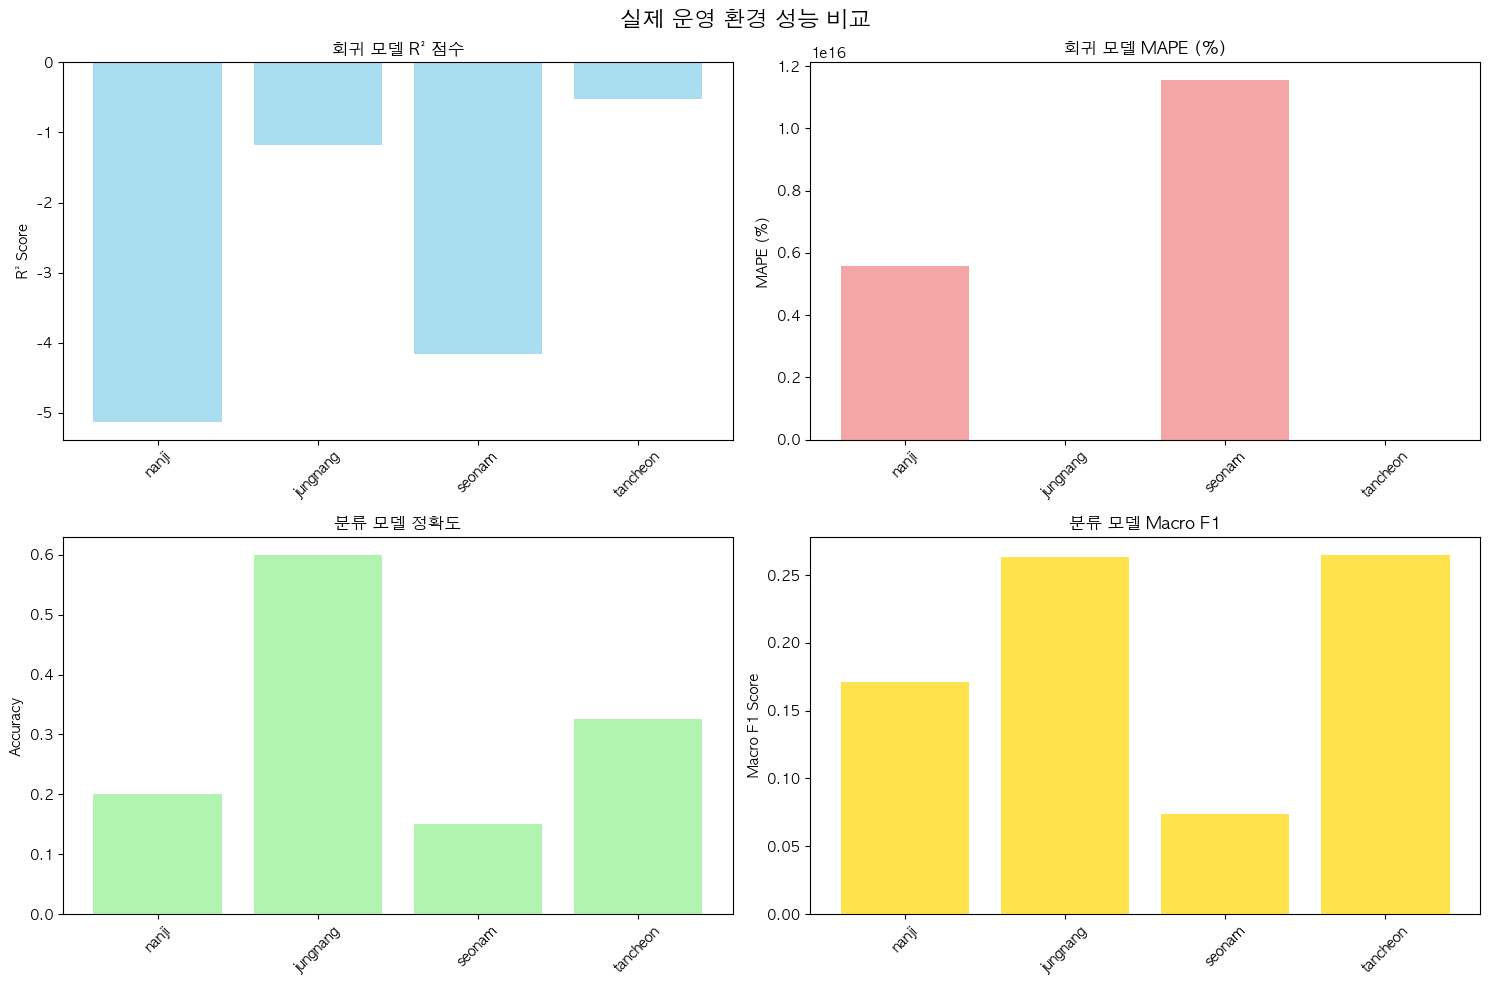


예측 결과 저장: production_simulation_20250826_211521_predictions.csv
성능 요약 저장: production_simulation_20250826_211521_summary.csv
학습 결과 저장: production_simulation_20250826_211521_training.csv

모든 결과가 저장되었습니다. 파일명 접두사: production_simulation_20250826_211521

파이프라인 실행 완료! 소요시간: 204.4초

--- 실제 운영 성능 최종 요약 ---

NANJI:
  regression: {'model_name': 'XGBoost_Reg', 'prediction_count': 40, 'mae': 586597.3953125, 'rmse': 648086.9997079202, 'r2': -5.124026520836579, 'mape': 5576049125000005.0, 'mean_actual': 151011.325, 'mean_predicted': 737608.7203125}
  classification: {'model_name': 'XGBoost_Clf', 'prediction_count': 40, 'accuracy': 0.2, 'macro_f1': 0.17132867132867133, 'weighted_f1': 0.09125874125874125, 'extreme_f1': 0.0625, 'correct_count': 8, 'total_count': 40}

JUNGNANG:
  regression: {'model_name': 'CatBoost_Reg', 'prediction_count': 40, 'mae': 262010.53536270914, 'rmse': 325195.01777793164, 'r2': -1.1751110876226867, 'mape': 51.64453857633078, 'mean_actual': 1220909.1, 'mean_predicted': 146365

In [6]:
# ================================================================================================
# 셀 2: 최종 실행
# ================================================================================================
# results = run_safe_production_pipeline(cutoff_date='2025-05-20')
# 새로 추가
results = run_complete_production_pipeline(cutoff_date='2025-05-20')

'''
if results:
    final_table, trained_models, performance_summary = results
    print("\n--- 최종 결과 요약 ---")
    print(pd.DataFrame(performance_summary))'''
    
    
if results:
    final_table, trained_models, production_performance = results
    print("\n--- 실제 운영 성능 최종 요약 ---")
    if production_performance:
        for center, perf in production_performance.items():
            print(f"\n{center.upper()}:")
            for task, metrics in perf.items():
                print(f"  {task}: {metrics}")

# 새로 하는거
